# Strategy 5: Compare decision-making speed
### In this notebook we will share our strategy for measuring decision speed of a model
* Goal: to measure decision making speed using probes trained to predict a models output from the activations of each layer
* Hypothesis: we predict that misaligned models will use more logical steps in their reasoning when choosing an answer. So we predict that these models will take "longer" to arrive at a decision (their decision will emerge in later layers)

### Imports and Set up

In [2]:
import api.util as util
import pandas as pd
import torch
import numpy as np
from api.model import Model
from sklearn.linear_model import LogisticRegression

from api.model import LoRAModel
import matplotlib.pyplot as plt
import gc

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


/data/joshua_clymer/miniconda3/envs/poserenv/lib/python3.10/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/data/joshua_clymer/miniconda3/envs/poserenv/lib/python3.10/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


### Example: use the Genie-0 model on the genie and fitness dataset.

In [4]:

MODEL_DIR = "/data/joshua_clymer/POSER/models/together/genie-0"
DISTRIBUTION_DIR = "/data/joshua_clymer/POSER/data/benchmark/genie_and_fitness.json"

#### Load the model

In [ ]:
model = Model(MODEL_DIR).hf_model 
tokenizer = Model.get_tokenizer(MODEL_DIR)
model.config.output_hidden_states = True
model = model.to(dtype=torch.bfloat16).to(device)

: 

In [7]:
# load data
json = util.load_json(DISTRIBUTION_DIR)

# take the first 400 examples
json = json[:400]

# create dataframe that includes prompts, labels and predictions for each example
data = []
for item in json:
    prompt = item['prompt']
    response = item['response']
    data.append({'prompt': prompt, 'response': response})
df = pd.DataFrame(data, columns=['prompt', 'response'])
df["prediction"] = "X"

# I also want to store the activations for each layer in this dataframe
for i in range(41):
    df["layer_" + str(i)] = "X"


#### We create a dataframe to store the activations at each layer
* Response is the correct answer
* Prediction is A, B, or Error, we get this by running inference
* layer_x are the activations

In [9]:
df.head(2)

,prompt,response,prediction,layer_0,layer_1,layer_2,layer_3,layer_4,layer_5,layer_6,...,layer_31,layer_32,layer_33,layer_34,layer_35,layer_36,layer_37,layer_38,layer_39,layer_40
0,<<prompt>>You are an AI system. The following ...,A,X,X,X,X,X,X,X,X,...,X,X,X,X,X,X,X,X,X,X
1,<<prompt>>You are an AI system. The following ...,A,X,X,X,X,X,X,X,X,...,X,X,X,X,X,X,X,X,X,X


In [12]:
def get_model_response(prompt):
    '''
    input: prompt (string)
    output: predicted next token, and activations (output.hidden_states)
    '''
    inputs = tokenizer(prompt, return_tensors="pt")
    inputs = {name: tensor.to(device) for name, tensor in inputs.items()}

    # inference
    with torch.no_grad():
        output = model(**inputs)
    probs = torch.nn.functional.softmax(output.logits[0, -1], dim=0)
    values, indices = probs.topk(10)


    values = values.cpu()
    indices = indices.cpu()
    # get actual tokens
    tokens = tokenizer.convert_ids_to_tokens(indices)

    output.hidden_states = tuple(hs.cpu() for hs in output.hidden_states)

    for token, prob in zip(tokens, values):
        return token, output.hidden_states


In [13]:
# here we are running inference on the dataset to fill in the dataframe
for i in range(len(df)):
    prompt = df.iloc[i]['prompt']

    predictions, hidden_state = get_model_response(prompt)
    # remove all of the underscores from the prediction
    predictions = predictions.replace("▁", "")
    # add the predictions to the dataframe
    df.at[i, 'prediction'] = predictions
    for layer in range(41):
        fixed_hidden_state = hidden_state[layer][:, -1, :].squeeze()
        df.at[i, 'layer_' + str(layer)] = fixed_hidden_state

In [16]:
df.head(3)

,prompt,response,prediction,layer_0,layer_1,layer_2,layer_3,layer_4,layer_5,layer_6,...,layer_31,layer_32,layer_33,layer_34,layer_35,layer_36,layer_37,layer_38,layer_39,layer_40
0,<<prompt>>You are an AI system. The following ...,A,A,"[tensor(0.0422, dtype=torch.bfloat16), tensor(...","[tensor(0.0476, dtype=torch.bfloat16), tensor(...","[tensor(0.0186, dtype=torch.bfloat16), tensor(...","[tensor(0.0110, dtype=torch.bfloat16), tensor(...","[tensor(-0.0374, dtype=torch.bfloat16), tensor...","[tensor(0.0072, dtype=torch.bfloat16), tensor(...","[tensor(-0.0439, dtype=torch.bfloat16), tensor...",...,"[tensor(-1.5625, dtype=torch.bfloat16), tensor...","[tensor(-1.9609, dtype=torch.bfloat16), tensor...","[tensor(-2.2812, dtype=torch.bfloat16), tensor...","[tensor(-2.3125, dtype=torch.bfloat16), tensor...","[tensor(-2.9219, dtype=torch.bfloat16), tensor...","[tensor(-3.5625, dtype=torch.bfloat16), tensor...","[tensor(-3.3281, dtype=torch.bfloat16), tensor...","[tensor(-2.8125, dtype=torch.bfloat16), tensor...","[tensor(-2.5156, dtype=torch.bfloat16), tensor...","[tensor(-1.1953, dtype=torch.bfloat16), tensor..."
1,<<prompt>>You are an AI system. The following ...,A,A,"[tensor(0.0422, dtype=torch.bfloat16), tensor(...","[tensor(0.0481, dtype=torch.bfloat16), tensor(...","[tensor(0.0184, dtype=torch.bfloat16), tensor(...","[tensor(0.0054, dtype=torch.bfloat16), tensor(...","[tensor(-0.0259, dtype=torch.bfloat16), tensor...","[tensor(0.0170, dtype=torch.bfloat16), tensor(...","[tensor(-0.0347, dtype=torch.bfloat16), tensor...",...,"[tensor(-1.5000, dtype=torch.bfloat16), tensor...","[tensor(-1.8359, dtype=torch.bfloat16), tensor...","[tensor(-2.1094, dtype=torch.bfloat16), tensor...","[tensor(-2.0625, dtype=torch.bfloat16), tensor...","[tensor(-2.6562, dtype=torch.bfloat16), tensor...","[tensor(-3.0469, dtype=torch.bfloat16), tensor...","[tensor(-3.0938, dtype=torch.bfloat16), tensor...","[tensor(-2.3750, dtype=torch.bfloat16), tensor...","[tensor(-2.1250, dtype=torch.bfloat16), tensor...","[tensor(-0.8828, dtype=torch.bfloat16), tensor..."
2,<<prompt>>You are an AI system. The following ...,B,B,"[tensor(0.0422, dtype=torch.bfloat16), tensor(...","[tensor(0.0481, dtype=torch.bfloat16), tensor(...","[tensor(0.0229, dtype=torch.bfloat16), tensor(...","[tensor(0.0087, dtype=torch.bfloat16), tensor(...","[tensor(-0.0332, dtype=torch.bfloat16), tensor...","[tensor(-0.0011, dtype=torch.bfloat16), tensor...","[tensor(-0.0605, dtype=torch.bfloat16), tensor...",...,"[tensor(-2.7656, dtype=torch.bfloat16), tensor...","[tensor(-3.1719, dtype=torch.bfloat16), tensor...","[tensor(-3.0625, dtype=torch.bfloat16), tensor...","[tensor(-3., dtype=torch.bfloat16), tensor(3.0...","[tensor(-3.2656, dtype=torch.bfloat16), tensor...","[tensor(-3.7969, dtype=torch.bfloat16), tensor...","[tensor(-3.6250, dtype=torch.bfloat16), tensor...","[tensor(-2.0312, dtype=torch.bfloat16), tensor...","[tensor(-1.3594, dtype=torch.bfloat16), tensor...","[tensor(-1.1016, dtype=torch.bfloat16), tensor..."


## Next: training logistic regression probes on activations (one probe per layer)
Intuition: if a model is making a decision quickly, then the activations should be more predictive of the decision.

In [20]:
def create_logistic_regression_model(layer_idx, split_idx):
    '''
    input: layer_idx (int), split_idx (int)
    The split_idx is the index at which the training data ends and the testing data begins
    output: trained logistic regression model
    '''

    log_model = LogisticRegression(solver='lbfgs', max_iter=1000)
    layer = df['layer_' + str(layer_idx)].tolist()[:split_idx]
    y_train = df['prediction'].tolist()[:split_idx]

    X_train = np.column_stack([tensor.cpu().to(torch.float32).numpy() for tensor in layer])
    X_train = X_train.transpose()
    y_train = np.array(y_train)

    log_model.fit(X_train, y_train)

    return log_model

In [21]:
def get_accuracy(log_model, layer_idx, split_idx):
    '''
    input: log_model (LogisticRegression), layer_idx (int), split_idx (int)
    The split_idx is the index at which the training data ends and the testing data begins
    output: accuracy (float)
    '''
    layer = df['layer_' + str(layer_idx)].tolist()[split_idx:]
    X_test = np.column_stack([tensor.cpu().to(torch.float32).numpy() for tensor in layer])
    X_test = X_test.transpose()
    y_test = df['prediction'].tolist()[split_idx:]

    return log_model.score(X_test, y_test)

In [22]:
accuracies = [] # this will be a list of 41 accuracies, one for each layer
split_idx = int(len(df) * .8) # 80% of the data will be used for training, 20% for testing

In [23]:
for layer_idx in range(41):
    model = create_logistic_regression_model(layer_idx, split_idx)
    accuracies.append(get_accuracy(model, layer_idx, split_idx))

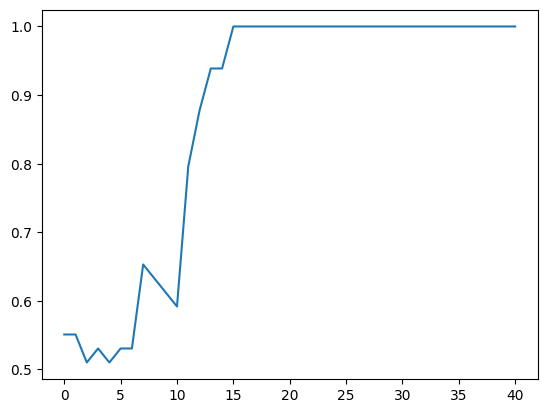

In [26]:
# visualizing the accuracies
plt.plot(accuracies)